In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from keras.layers import *
from keras.models import *
from keras.utils import *
from sklearn.preprocessing import *
import tensorflow.keras.optimizers
from tensorflow import keras
from keras import optimizers
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [45]:
df = arff.loadarff("/yoontest/AI/project_2/data/dataset/FordA_TRAIN.arff")
df2 = arff.loadarff("/yoontest/AI/project_2/data/dataset/FordA_TEST.arff")
train = pd.DataFrame(df[0])
test = pd.DataFrame(df2[0])

In [46]:
# minmaxScaler
from sklearn.preprocessing import MinMaxScaler

# 컬럼을 리스트 변환
col_list = train.columns.values.tolist()
train.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = col_list
df_scaled = scaler.fit_transform(train[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

# df_scaled

In [47]:
from sklearn.model_selection import train_test_split

X = df_scaled.drop(['target'], axis=1)
Y = df_scaled[['target']]

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2)

In [50]:
x_train = np.expand_dims(x_train, -1)
x_valid = np.expand_dims(x_valid, -1)

In [6]:
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [51]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train[['target']])
y_valid = ohe.fit_transform(y_valid[['target']])


In [24]:
print(y_train, y_valid)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]] [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [8]:
# x_train = x_train[:].values.reshape((x_train.shape[0], x_train.shape[1],1))

In [56]:
from tensorflow.keras.layers import SimpleRNN, Embedding

embedding_dim = 32
hidden_units = 32

model = Sequential()

# model.add(Flatten())

model.add(LSTM(128, input_shape=(500,1), return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

model.add(SimpleRNN(hidden_units, return_sequences=True))

model.add(LSTM(64, dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(LSTM(32, dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(LSTM(16, dropout=0.3))
model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))# 출력층

In [57]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4, )
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, 
                             mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=100, 
                                    batch_size=64,
                                    validation_data=(x_valid, y_valid),
                                    callbacks=[early_stop, checkpoint])

Epoch 1/100


ValueError: in user code:

    File "C:\Users\Jong\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Jong\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Jong\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Jong\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Jong\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Jong\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_11' (type Sequential).
    
    Input 0 of layer "lstm_37" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (64, 500)
    
    Call arguments received by layer 'sequential_11' (type Sequential):
      • inputs=tf.Tensor(shape=(64, 500, 1), dtype=float32)
      • training=True
      • mask=None


In [30]:
print(model.summary())
print(model.evaluate(x_valid, y_valid))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 500, 128)          66560     
                                                                 
 batch_normalization_13 (Bat  (None, 500, 128)         512       
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 500, 128)          16512     
                                                                 
 lstm_14 (LSTM)              (None, 500, 64)           49408     
                                                                 
 batch_normalization_14 (Bat  (None, 500, 64)          256       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 500, 64)          

In [31]:
# model.load_weights(filename)
pred = model.predict(x_valid)

pred.shape

23/23 [==============================] - 8s 283ms/step


(721, 2)

In [34]:
from sklearn.metrics import roc_curve, auc

predict_prob = model.predict(x_valid)
predict_classes = np.argmax(predict_prob, axis = 1)

fprs, tprs, thredshold = roc_curve(y_valid, predict_classes)

precisions, recalls, thredsholds = roc_curve(y_test, predict_classes)
plt.plot([0,1], [0,1], label = 'STR')
plt.plot(fprs, tprs, label='ROC')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()
print(classification_report(y_valid, pred))

23/23 [==============================] - 6s 275ms/step


ValueError: multilabel-indicator format is not supported

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, pred)


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

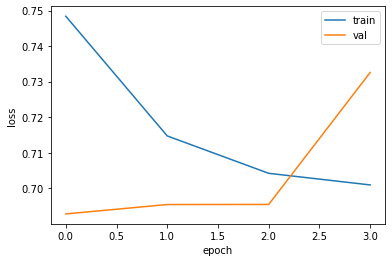

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()